# Blacklisted words in Swedish judgements
The Swedish Justice Departement has published a [list](https://www.regeringen.se/rapporter/2011/10/pm-20111/) of words that can be replaced to improve readability. This notebook is used to track the occurences of these words in public jugdments.

In [223]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import os
import urllib.request
from urllib import parse
import urllib.parse
import regex as re
import pandas as pd
from joblib import Memory
from datetime import datetime
import textract
from collections import Counter
import matplotlib.pyplot as plt
import csv
import itertools
import json

memory = Memory('./cache', verbose=0)

# Att göra (Snälla <3):
# Alfabetisk ordning. 
# Lista med alla domars namn. Går det att få en lista för varje domstol?
    # Saker för kontroll. Eventuellt om vi kan hitta nyhetsartiklar att jämföra med. 

In [432]:
@memory.cache
def text_from_url(url):
    urllib.request.urlretrieve(url, "./cache/temp.pdf")
    return textract.process('./cache/temp.pdf', encoding='utf-16').decode('utf-16')

@memory.cache
def get_domstol_se(section_url):
    BASE_URL = "https://www.domstol.se/"
    URL = BASE_URL + section_url
    BANNER_CLASS_NAME = "banner__button"
    MORE_CLASS_NAME = "search-result-item__show-more-btn"
    
    urls = []
    driver = webdriver.Chrome('./chromedriver')
    wait = WebDriverWait(driver, 10)
    driver.get(URL)
    sleep(1.0)
    
    banner_button = driver.find_element_by_class_name(BANNER_CLASS_NAME)
    more_button = driver.find_element_by_class_name(MORE_CLASS_NAME)
    
    wait.until(EC.element_to_be_clickable((By.CLASS_NAME, BANNER_CLASS_NAME)))
    banner_button.click()
        
    while True:
        more_button.click()
        try:
            wait.until(EC.element_to_be_clickable((By.CLASS_NAME, MORE_CLASS_NAME)))
        except:
            break
        
    results = driver.find_elements_by_class_name("u-pr-huge--large")
    urls =  [item.get_attribute("href") for item in results]
    driver.close()
    return tuple(urls)


@memory.cache
def data_from_pdf_page(url):
    BASE_URL = "https://www.domstol.se/"
    page = requests.get(url)
    soup = BeautifulSoup(page.text, "html.parser")

    pdf_element = soup.find("a", href=re.compile(r".+\.pdf"))
    date_element = soup.find("span", class_ = "publisher__byline")
   
    if pdf_element is None:
        print('Failed, no pdf', url)
        return None
    elif date_element is None:
        print('Failed, no date', url)
        return None
    else:
        date = datetime.fromisoformat(date_element.text[:-1])
        pdf_url = BASE_URL + pdf_element["href"]
        file_name = re.findall(r"(.+\/)*(.+\..+)$", pdf_url)[0][1]
        text = text_from_url(pdf_url)
        return {"date": date, "url": pdf_url, "text": text}
    
def words(text):
    """
    Returns a list of words from a text.
    """
    text = text.lower()
    text = re.sub('\n', " ", text)
    text = re.sub('[/./?,!/:/(/)_]', "", text)
    text = re.sub('[0-9]', "", text)
    words = text.split()
    return words

# This does not work for the urls that contains non-ascii characters. 
@memory.cache
def get_migrations():
    data = []
    
    # From csv
    with open("./migrations_dommar.csv", newline='',  encoding='utf-8-sig') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            date = row['Date']
            url = row['Url']
            if url[-3:] != "pdf":
                data.append(data_from_pdf_page(url))
                continue
            try:
                urllib.request.urlretrieve(url, "./cache/temp.pdf")
            except:
                print("Could not fetch ", date, url)
                continue
            text = textract.process('./cache/temp.pdf', encoding='utf-16').decode('utf-16')
            data.append({'date': datetime.fromisoformat(date), 'url': url, 'text': text})
            
    # From folder
    folder = './MigrationsoÌverdomstolen avgoÌranden/'
    for file_name in os.listdir(folder):
        print(file_name)
        date = file_name[:10]
        url = folder + file_name
        text = textract.process(url, encoding='utf-16').decode('utf-16')
        data.append({'date': datetime.fromisoformat(date), 'url': url, 'text': text})
    
    return tuple(data)

@memory.cache
def get_arbets():
    data = []
    URL = "http://www.arbetsdomstolen.se/pages/page.asp?lngID=4&lngLangID=1&Year={}"
    BASE = "http://www.arbetsdomstolen.se/pages/page.asp"
    for year in range(2003, 2020):
        page = requests.get(URL.format(year))
        soup = BeautifulSoup(page.text, 'html.parser')
        content = soup.find(id="content")

        for element in content.find_all("li"):
            result_url = element.find("a")['href']
            pdf_url = _arbets_pdf(BASE + result_url)
            title = element.find("strong").contents[0]
            date = re.findall("\d{4}-\d{2}-\d{2}", title)[0]
            if pdf_url is not None:
                try:
                    text = text_from_url(pdf_url)
                except:
                    print("Failed", pdf_url)
                    continue
                data.append({"date": datetime.fromisoformat(date), "url": pdf_url, "text": text})
                print("Downloaded", pdf_url)

    return tuple(data)

def _arbets_pdf(url):
    BASE = "http://www.arbetsdomstolen.se/"
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    for link in soup.find_all("a"):
        if re.match(r".+\.pdf", str(link.get('href'))):
            return BASE + link['href'][2:]
    
    return None

def _id(text):
    return re.findall('[A-ZÅÄÖ] \d{1,4}[-\/]\d{2}', text)[0]

def _id_hfd(text):
    return re.findall('\d{2,4}-\d{2}', text)[0]

def _id_mig(text):
    return re.findall('[A-Z]{0,3}\d{1,5}-\d{1,2}', text)[0]

### Downloading and sorting data from decisions.

In [433]:
# Adding decistions from Högsta Domstolen
df_hd = pd.DataFrame([data_from_pdf_page(url) for url in get_domstol_se("hogsta-domstolen/avgoranden/?f=DecisionType_list:decision") if data_from_pdf_page(url) is not None])
df_hd = df_hd.loc[df_hd['text'].apply(lambda x: not x.isspace())]
df_hd["type"] = "HD"
df_hd["id"] = df_hd['text'].apply(_id)

In [474]:
# Adding decistions from Högsta förvaltningsdomstolen
df_hfd = pd.DataFrame([data_from_pdf_page(url) for url in get_domstol_se("hogsta-forvaltningsdomstolen/avgoranden/") if data_from_pdf_page(url) is not None])
df_hfd = df_hfd.loc[df_hfd['text'].apply(lambda x: not x.isspace())]
df_hfd["type"] = "HFD"
df_hfd["id"] = df_hfd['text'].apply(_id_hfd)

In [480]:
# Adding descisions from Migrationsdomstolen
df_mig = pd.DataFrame(get_migrations())
df_mig = df_mig.loc[df_mig['text'].apply(lambda x: not x.isspace())]
df_mig["type"] = "MIG"
df_mig["id"] = df_mig['text'].apply(_id_mig)

In [481]:
# Adding descisions from Arbetsdomstolen
df_ad = pd.DataFrame(get_arbets())
df_ad = df_ad.loc[df_ad['text'].apply(lambda x: not x.isspace())]
df_ad["type"] = "AD"
df_ad["id"] = df_ad['text'].apply(_id)

In [478]:
df = pd.DataFrame().append([df_hd, df_hfd, df_mig, df_ad])

### Searching and counting blacklisted words

In [533]:
# Counting words
df['word_count'] = list(map(lambda x: Counter(words(x)), df['text']))
df['n_words'] = list(map(lambda x: len(words(x)), df['text']))

# Counting occurences of blacklisted words
with open('./svartlistadeord.txt') as f:
    illegal_words = tuple(f.read().splitlines())
    
with open('./svartlistadeordstammar.txt') as f:
    illegal_word_stems = tuple(f.read().splitlines())
    
# TODO: text.lower()
def illegal_count(text):
    counter = Counter()
    for word in illegal_word_stems:
        key = r"\s(" + word + "\p{L}+)"
        matches = re.finditer(key, text)
        counter.update([m.group(1) for m in matches])
        
    for word in illegal_words:
        key = r"\s(" + word + ")"
        matches = re.finditer(key, text)
        counter.update([m.group(1) for m in matches])
        
    return counter
    
df['illegal_count'] = list(map(illegal_count, df['text']))
df['n_illegal_occurences'] = list(map(lambda x: sum(x.values()), df['illegal_count']))

# Calculating the ratio of blacklisted words
df['illegal_ratio'] = df['n_illegal_occurences']/df['n_words']
df.set_index('date', inplace=True)
df = df.sort_index()

### Using news articles as controll
234,196 news articles from 2016 is used as control. The dataset can be found here: 
https://webhose.io/free-datasets/swedish-news-articles/

In [ ]:
news = []
for filename in os.listdir('./news'):
    with open('./news/' + filename) as f:
        news.append(json.load(f))

df_news = pd.DataFrame(news)
df_news['n_words'] = df_news['text'].apply(lambda x: len(words(x)))
df_news['illegal_count'] = df_news['text'].apply(illegal_count)
df_news['n_illegal_occurences'] = df_news['illegal_count'].apply(lambda x: sum(x.values()))
df_news['illegal_ratio'] = df_news['n_illegal_occurences']/df_news['n_words']

### Number of decisions of each class:

In [534]:
df.groupby('type')['text'].count()

type
AD      832
HD     1695
HFD    1388
MIG      83
Name: text, dtype: int64

### Mean percent blacklisted words:

In [541]:
print(df.groupby('type')['illegal_ratio'].mean().apply(lambda x: str(round(x*100, 2))+"%"))
print()
print("Control\t",  str(round(df_news['illegal_ratio'].mean()*100, 2))+"%")

type
AD     0.57%
HD     0.58%
HFD    0.46%
MIG    0.35%
Name: illegal_ratio, dtype: object

Control	 0.12%


### Plotting percent blacklisted words

Text(0.5, 1.0, 'Procent svartlistade ord')

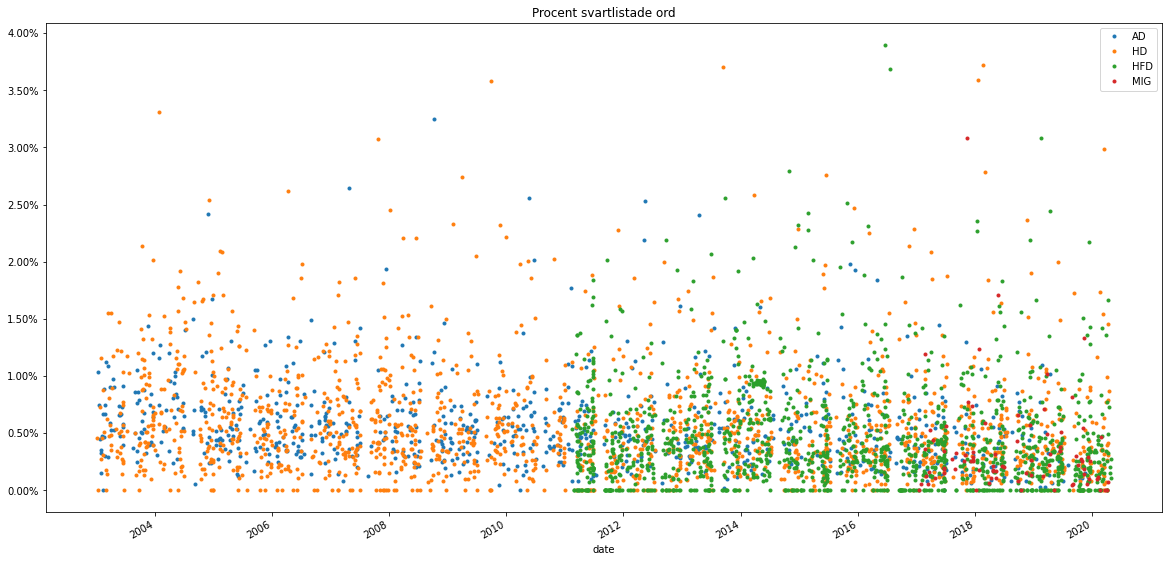

In [469]:
import matplotlib.ticker as mtick
ax = df.groupby(['type'])['illegal_ratio'].plot(style='o', ms=3, figsize=(20,10))
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax[0].legend()
ax[0].set_title("Procent svartlistade ord")

### ... Applying rolling average for clarity

Text(0.5, 1.0, 'Procent svartlistade ord (rullande medelvärde 500 dommar)')

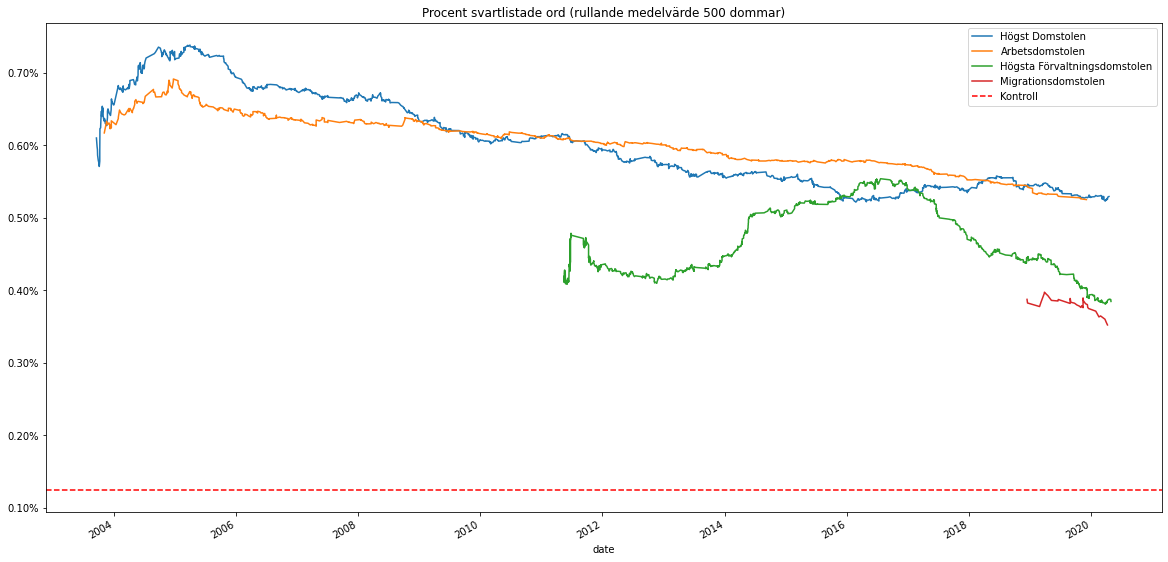

In [551]:
win_size = 500
ax = df.loc[df['type'] == 'HD']['illegal_ratio'].rolling(win_size, min_periods = 50).mean().plot(label="Högst Domstolen", figsize=(20,10))
df.loc[df['type'] == 'AD']['illegal_ratio'].rolling(win_size, min_periods = 50).mean().plot(label="Arbetsdomstolen")
df.loc[df['type'] == 'HFD']['illegal_ratio'].rolling(win_size, min_periods = 50).mean().plot(label="Högsta Förvaltningsdomstolen")
df.loc[df['type'] == 'MIG']['illegal_ratio'].rolling(win_size, min_periods = 50).mean().plot(label="Migrationsdomstolen")

ax.axhline(y=df_news['illegal_ratio'].mean(), color='r', linestyle='dashed', label="Kontroll")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.legend()
ax.set_title("Procent svartlistade ord (rullande medelvärde {} dommar)".format(win_size))

## Most common blacklisted words

In [471]:
counter = Counter()
for count in df['illegal_count'].iloc:
    counter += count
counter.most_common(20)

[('företa', 8871),
 ('föreligger', 5847),
 ('förelegat', 2816),
 ('förelegat ', 2168),
 ('föreligga', 2049),
 ('förelåg', 1741),
 ('underlåtit', 1314),
 ('föranlett', 1268),
 ('erfar', 1259),
 ('erfaren', 1218),
 ('förfall', 1093),
 ('erhållit', 969),
 ('nyttja', 850),
 ('underlåten', 848),
 ('erhålla', 808),
 ('föranleder', 708),
 ('jämkas', 679),
 ('föranleda', 656),
 ('erfor', 646),
 ('dröjsmål', 639)]

## Decisions of each class with highest percentage of blacklisted words:

In [472]:
df2 = df.reset_index()
df2.loc[df2.groupby(['type'])['illegal_ratio'].idxmax()][['url', 'type', 'illegal_ratio']]

,url,type,illegal_ratio
911,http://www.arbetsdomstolen.se//upload/pdf/2008/75-08.pdf,AD,0.032
3341,https://www.domstol.se//globalassets/filer/domstol/hogstadomstolen/avgoranden/20182/o-3827-17.pdf,HD,0.037
2847,https://www.domstol.se//globalassets/filer/domstol/hogstaforvaltningsdomstolen/avgoranden/2016/hfd-2016-ref.-52.pdf,HFD,0.039
3252,./MigrationsoÌverdomstolen avgoÌranden/2017-11-14.pdf,MIG,0.031


### Saving lists of decsitions

In [479]:
df.loc[df['type'] == "HD"]['id'].to_csv('hd.csv', header=None)
df.loc[df['type'] == "MIG"]['id'].to_csv('mig.csv', header=None)
df.loc[df['type'] == "AD"]['id'].to_csv('ad.csv', header=None)
df.loc[df['type'] == "HFD"]['id'].to_csv('hfd.csv', header=None)